<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Fundamental Factors](Introduction.ipynb) › Lesson 7: Profitability Growth
***

# Analyzing Profitability Growth with Alphalens

In the previous notebook, we saw that stocks of profitable companies (defined as companies with positive operating margins) perform better on a forward basis than stocks of unprofitable companies (defined as companies with negative operating margins). We looked at a snapshot of profitability, but that doesn't tell us anything about the trend of profitability over time. Our top quantile may have included companies that were profitable but in decline, and our bottom quantile may have included companies that were unprofitable but getting better. In this notebook, we'll modify our analysis to look not at profitability but at profitability growth, that is, the change in profitability over time.  

To measure profitability growth, we'll use the `PeriodicChange` factor, which calculates the change (positive or negative) in a factor over time.

> A `PeriodicPercentChange` factor, which calculates the percentage change rather than the change in value, is also available. `PeriodicPercentChange` is more appropriate for factors like `REVENUE` that scale with company size and thus can't be directly compared across companies of different sizes. `PeriodicChange` is more appropriate for ratios like operating margin that are already normalized as percentages and thus can be directly compared across company sizes.  

To use our operating margin factor with a built-in periodic factor like `PeriodicChange`, we need to put our factor logic inside a function that accepts `period_offset` and `mask` arguments: 

In [1]:
from zipline.pipeline import sharadar

def OPMARGIN(period_offset=0, mask=None):
    """
    Return an operating margin factor for the specified period_offset.
    """
    fundamentals = sharadar.Fundamentals.slice("ART", period_offset)
    revenue = fundamentals.REVENUE.latest
    operating_margin = fundamentals.OPINC.latest / revenue.where(revenue > 0) 

    # exclude companies with negative operating expenses or negative cost of revenue
    opex = fundamentals.OPEX.latest
    cor = fundamentals.COR.latest
    operating_margin = operating_margin.where((opex > 0) & (cor > 0))

    # clip range to (-1, 1) so as not to overweight outliers
    operating_margin = operating_margin.clip(min_bound=-1, max_bound=1)
    
    if mask is not None:
        operating_margin = operating_margin.where(mask)
        
    return operating_margin

We can then pass our function, as well as our base universe, to `PeriodicChange()` to create a factor for profitability growth. (Remember that putting our factor logic inside a function to pass to `PeriodicChange` is only necessary because we are computing a factor that's not available as a dataset column. To calculate growth using a dataset column such as `REVENUE`, we would pass the column directly to `PeriodicChange`.)

We'll look at the change over 1 year, which corresponds to a `window_length` of 4 since we are using trailing-twelve-month data:

In [2]:
from codeload.fundamental_factors.universe import CommonStocks, BaseUniverse
from zipline.pipeline.periodic import PeriodicChange

universe = BaseUniverse()
profitability_growth = PeriodicChange(OPMARGIN, window_length=4, mask=universe)

As in the previous notebook, we should further limit our universe to exclude `NaN`s from the pipeline output that will be passed to Alphalens. The following statement does that:

In [3]:
universe &= profitability_growth.notnull() # Python tip: writing `a &= b` is the same as writing `a = a & b`

In advance, it's not clear if an improving profit margin will be equally beneficial in profitable companies as in unprofitable companies. Does it matter more that a company is profitable, that it is growing in profitability, or both? Put differently, would it be better to own an unprofitable company that's getting better, or a profitable company that's getting worse?  To help sort through these questions, it would be helpful to see a separate breakdown of factor performance for profitable vs unprofitable companies. We can do this by including in our pipeline a boolean column for whether a company is currently profitable, to pass to Alphalens later: 

In [4]:
is_profitable = OPMARGIN(mask=universe) > 0

As in the previous notebook, we'll also include a size column so we can see a breakdown of the factor by size quantiles:

In [5]:
from zipline.pipeline import Pipeline

fundamentals = sharadar.Fundamentals.slice("ART")
marketcap = fundamentals.MARKETCAP.latest

pipeline = Pipeline(
    columns={
        'profitability_growth': profitability_growth,
        'is_profitable': is_profitable,
        'size': marketcap.quantiles(4, mask=universe) 
    },
    initial_universe=CommonStocks(),
    screen=universe
)

We then pass the pipeline object to Alphalens' `from_pipeline()` function. As in the previous notebook, we use `zero_aware=True` because 0 is the dividing line between companies whose profitability is growing and companies whose profitability is declining. Since `PeriodicChange()` is comparing current operating margin to the operating margin from 4 quarters ago, we must set the start date a year later than in the previous notebook to allow for the additional lookback window.  

,min,max,mean,std,count,avg daily count,count %
Profitability Growth Quantile,,,,,,,
1.0,-1.841,-0.018,-0.143,0.189,"4,262,031",712.8,23.1%
2.0,-0.055,-0.000,-0.011,0.009,"4,259,046",712.3,23.1%
3.0,0.000,0.047,0.008,0.007,"4,951,693",828.2,26.9%
4.0,0.003,1.892,0.134,0.186,"4,948,689",827.7,26.9%


,1D,21D,5D
Ann. alpha,0.047,0.024,0.025
beta,-0.091,-0.157,-0.103
Mean Relative Return Top Quantile (bps),1.336,0.728,1.013
Mean Relative Return Bottom Quantile (bps),-1.152,-0.557,-0.809
Mean Spread (bps),2.489,1.315,1.838


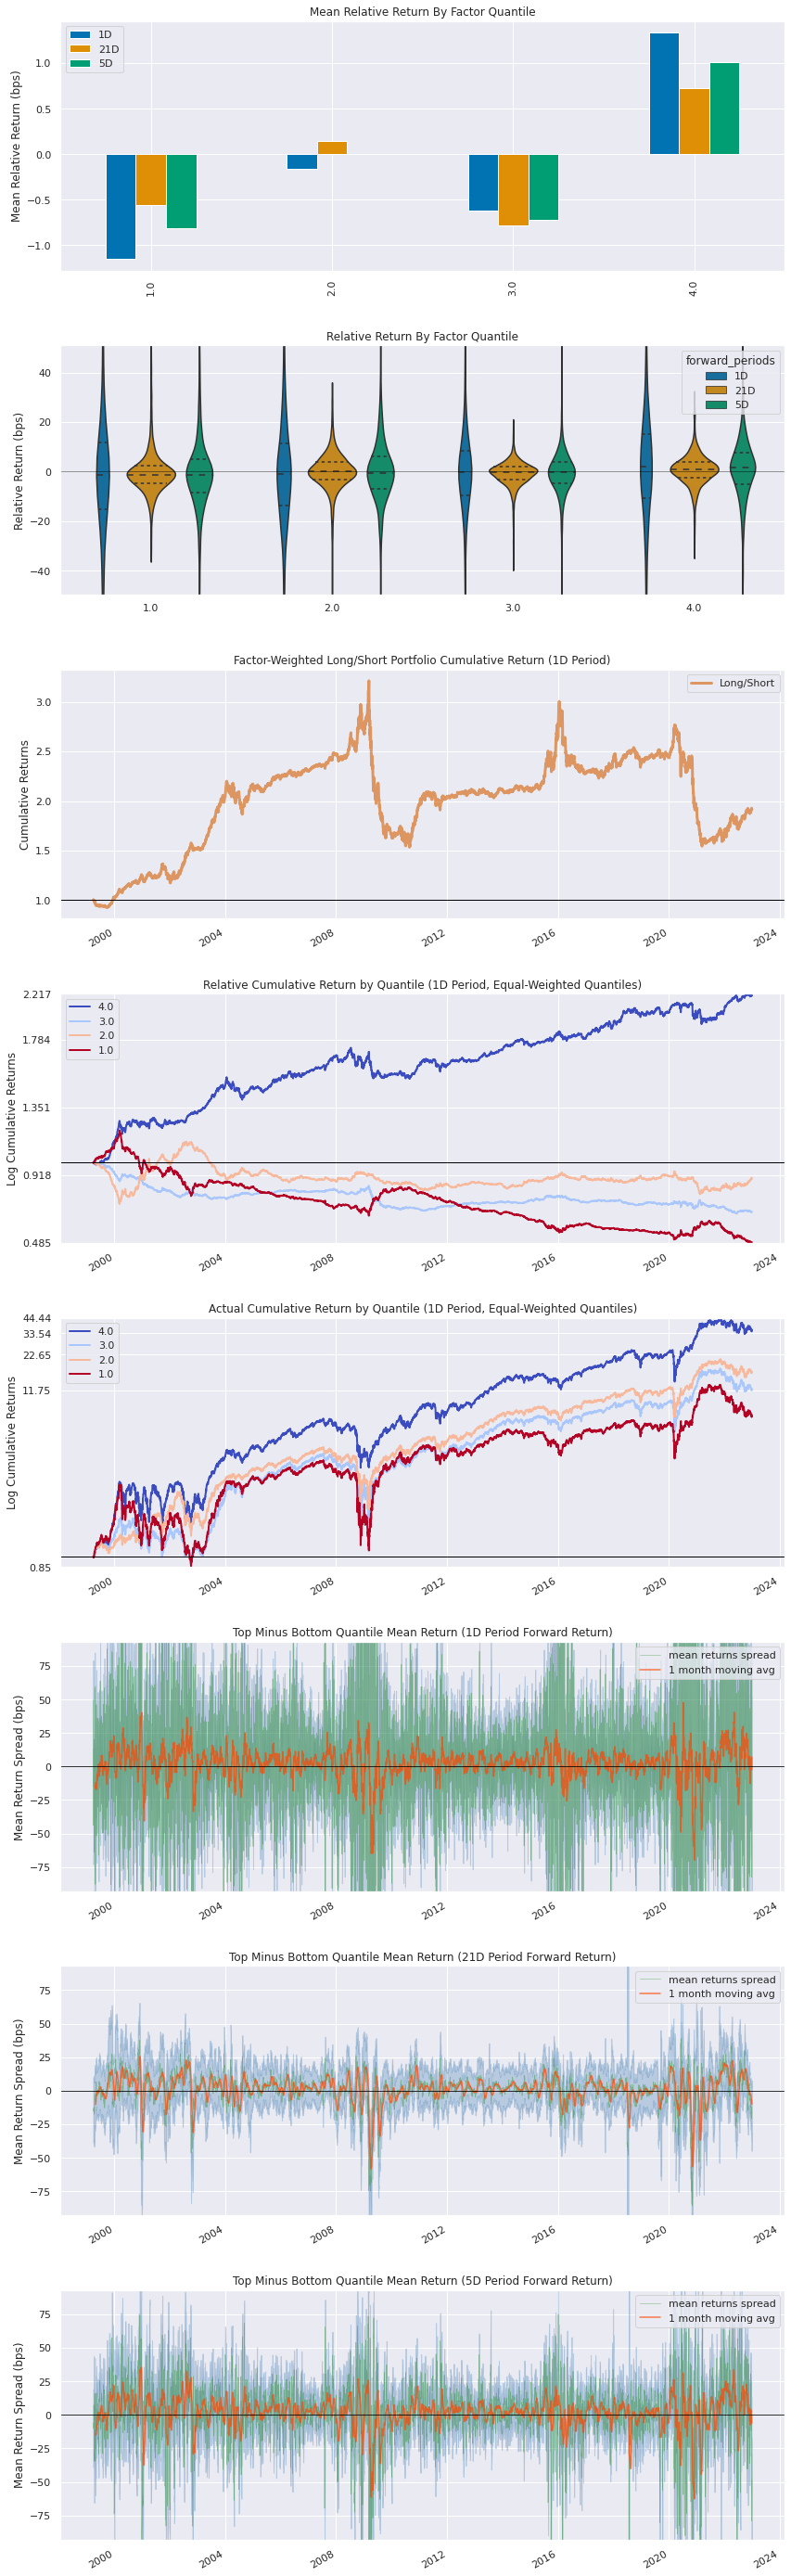

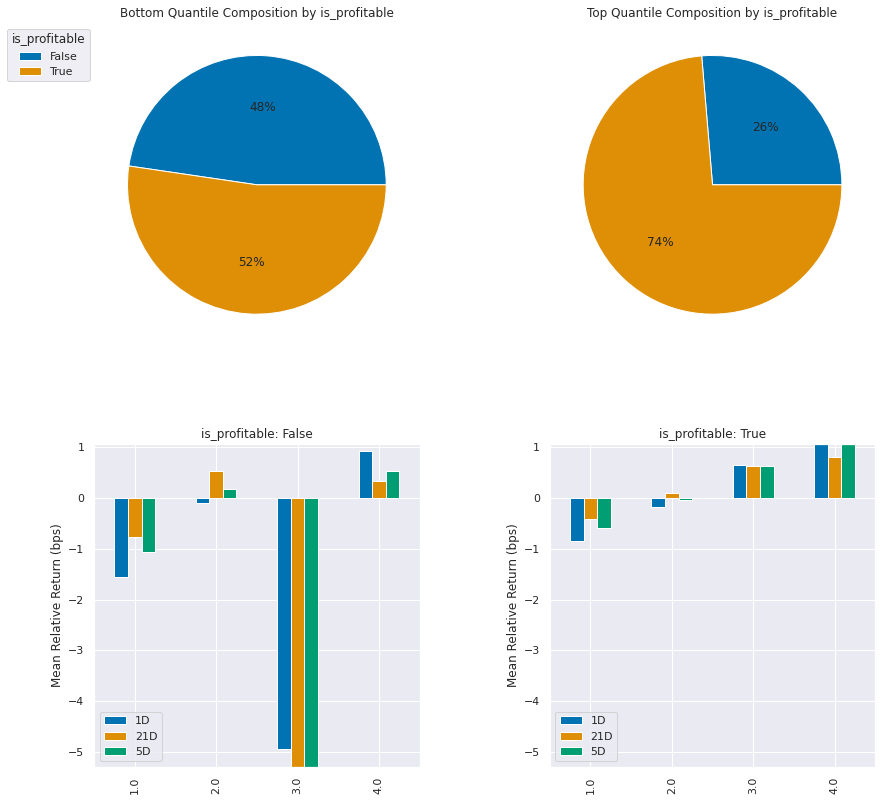

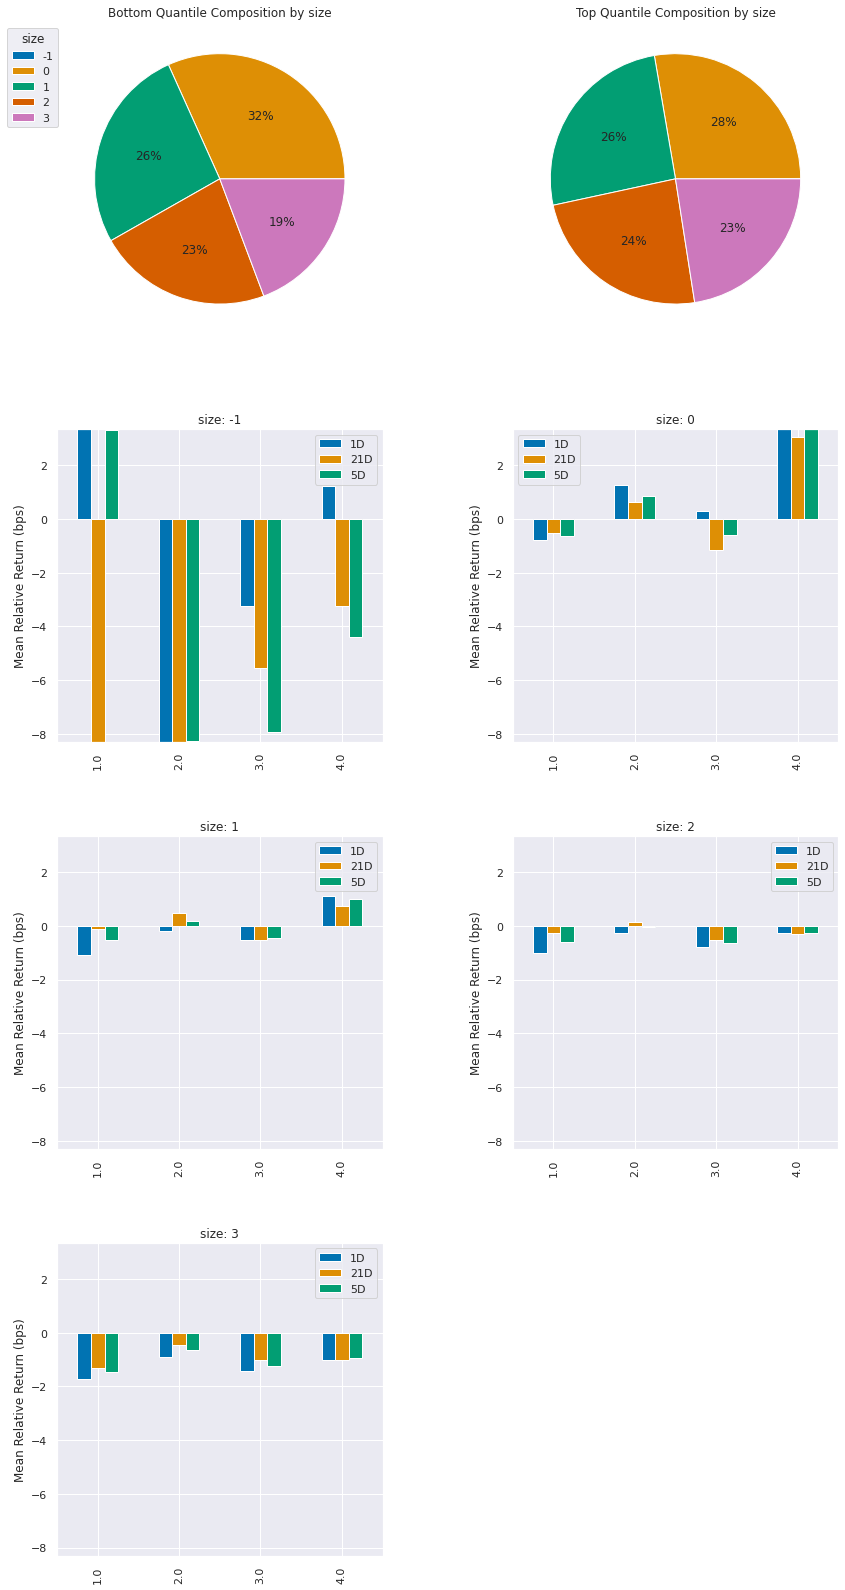

,1D,21D,5D
IC Mean,0.006,0.011,0.010
IC Std.,0.057,0.061,0.060
Risk-Adjusted IC,0.110,0.173,0.159
t-stat(IC),8.470,13.398,12.276
p-value(IC),0.000,0.000,0.000
IC Skew,-0.247,-0.772,-0.449
IC Kurtosis,1.557,2.154,1.358


/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


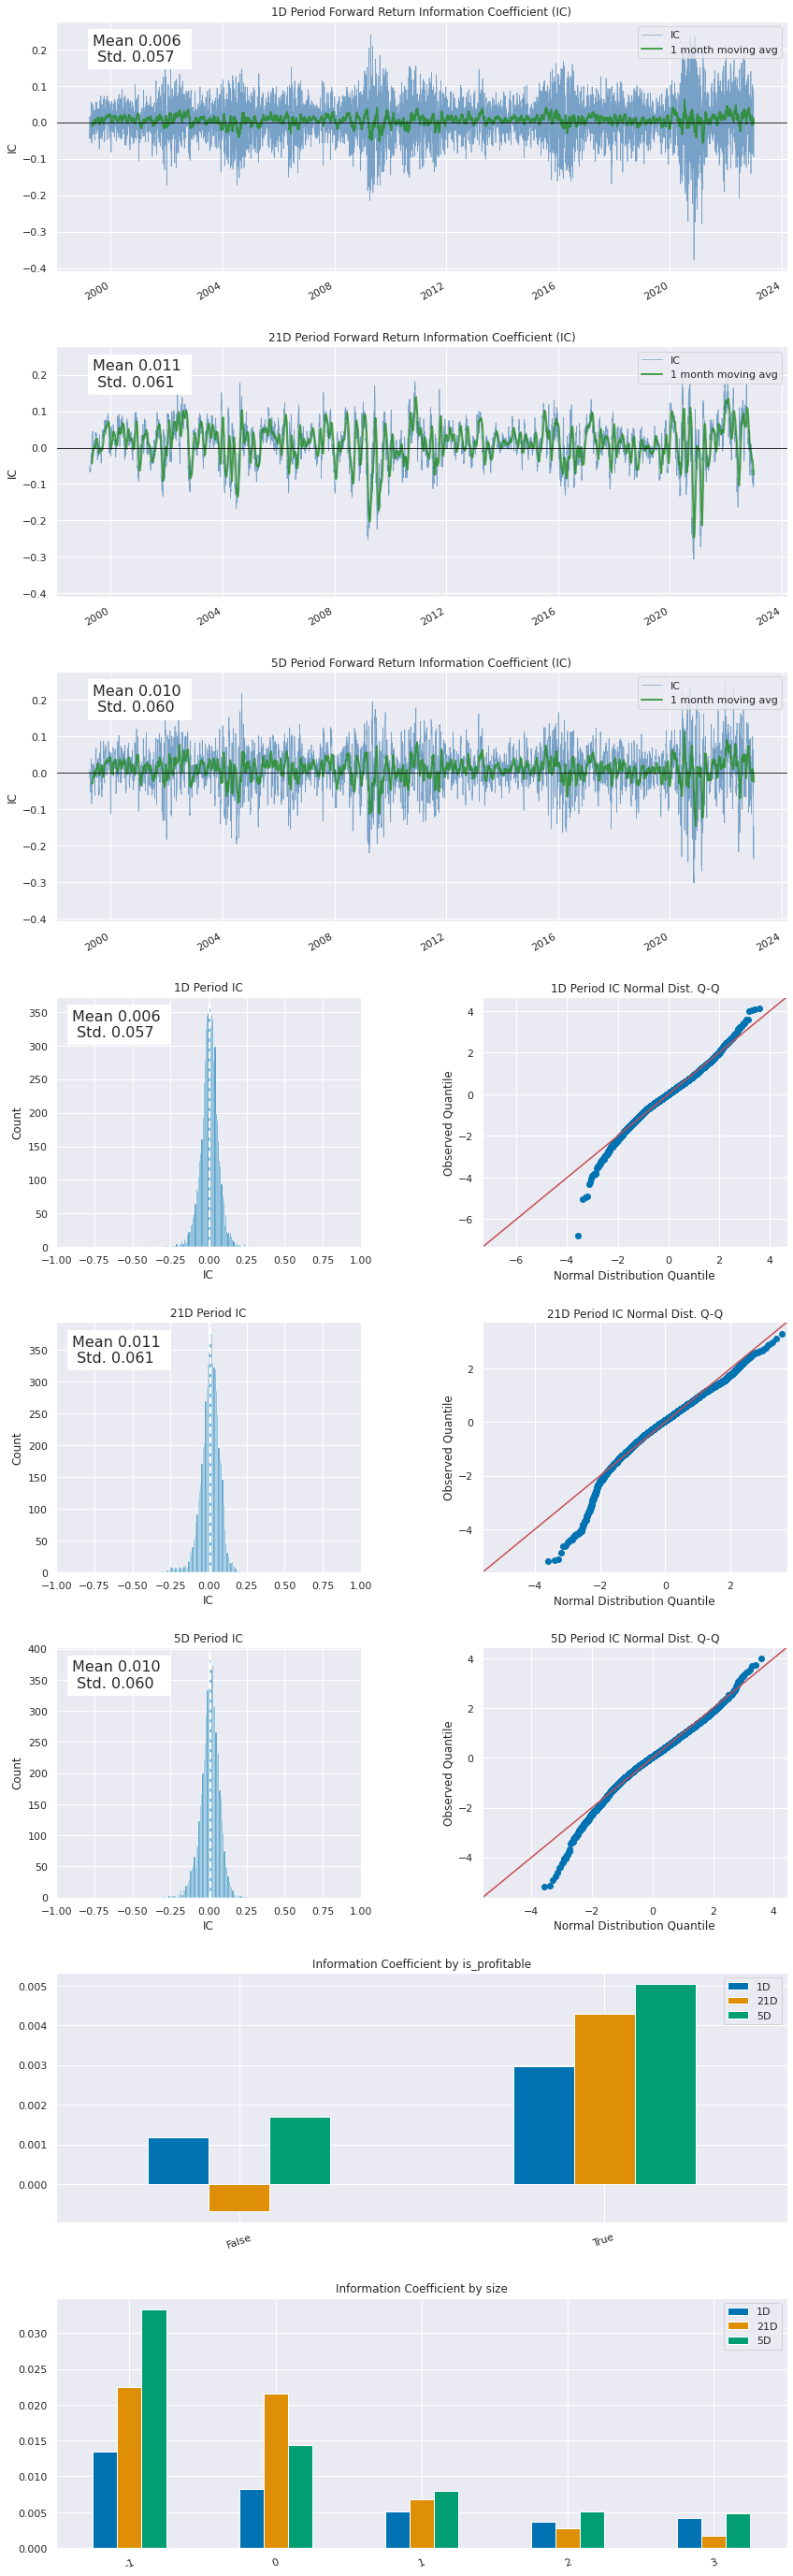

,1D,5D,21D
Quantile 1.0 Mean Turnover,0.008,0.036,0.134
Quantile 2.0 Mean Turnover,0.010,0.044,0.169
Quantile 3.0 Mean Turnover,0.009,0.042,0.159
Quantile 4.0 Mean Turnover,0.007,0.033,0.123


,1D,21D,5D
Mean Factor Rank Autocorrelation,0.995,0.906,0.977


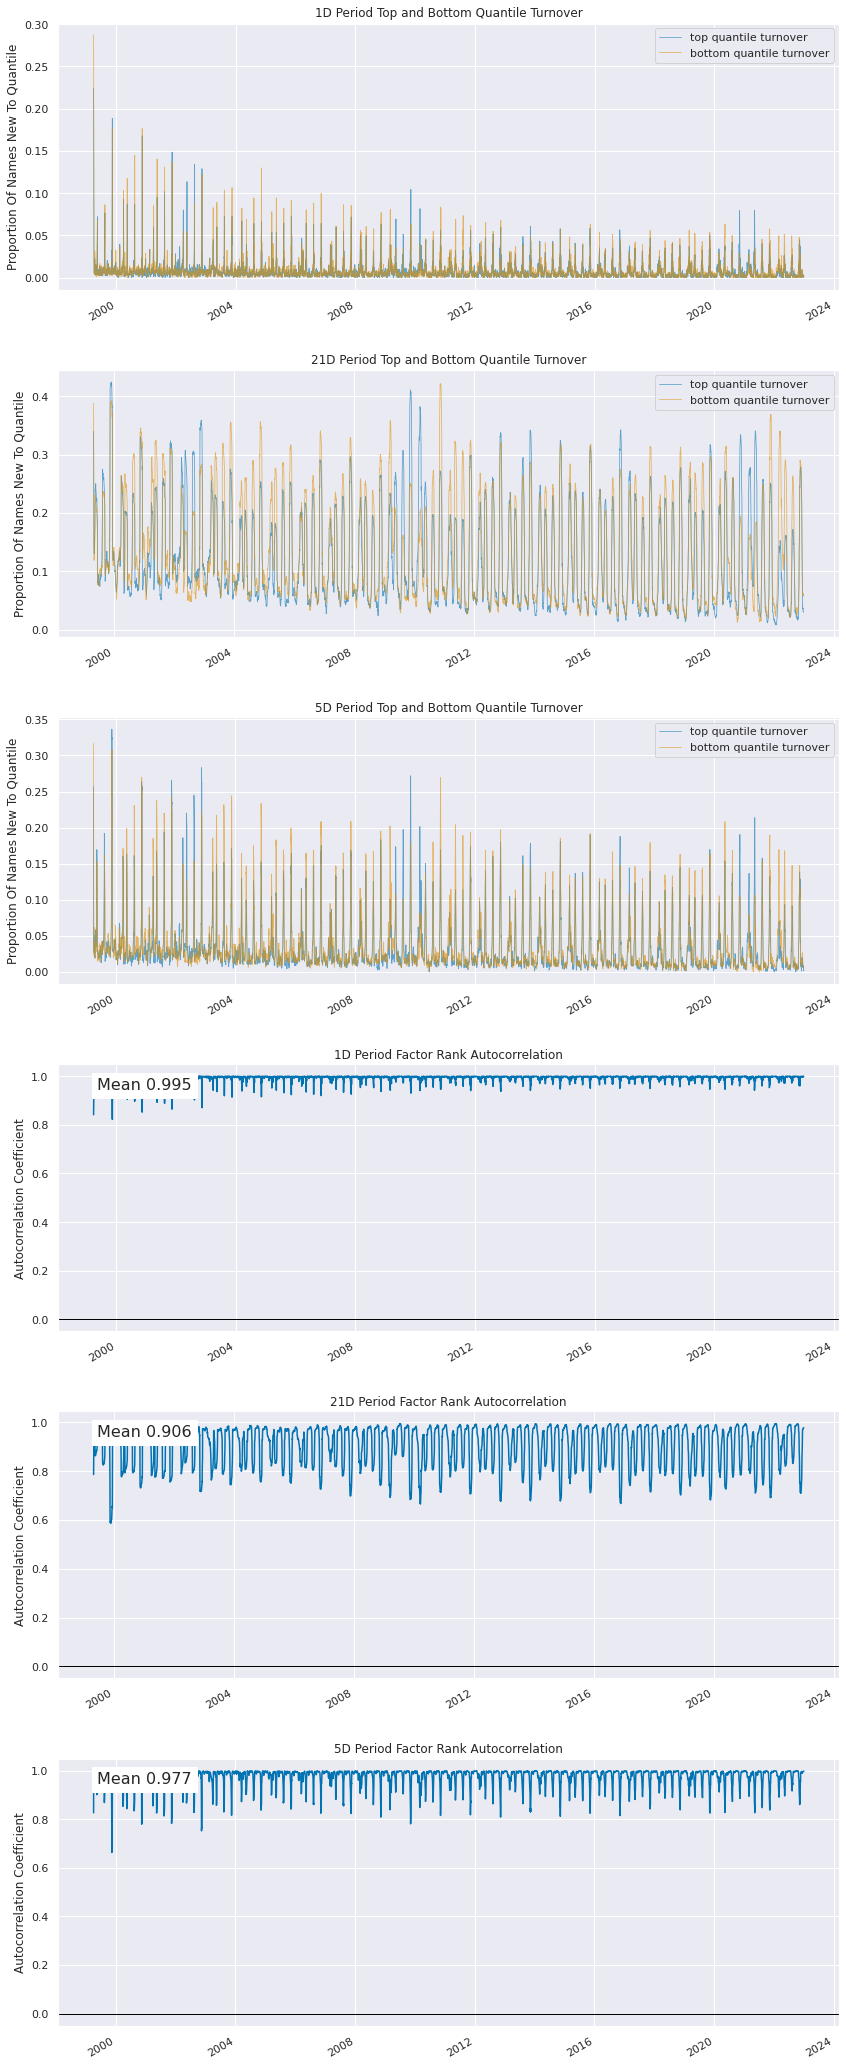

1D  ...  size
date       asset                                     ...      
1999-03-31 Equity(FIBBG000M7KQ09 [AAI])   -0.094486  ...    -1
           Equity(FIBBG000H83MP4 [AAI1])  -0.052632  ...     2
           Equity(FIBBG000BBVK30 [AAMRQ]) -0.021929  ...     4
           Equity(FIBBG000C2LZP3 [AAON])   0.023256  ...     1
           Equity(FIBBG000B9XRY4 [AAPL])   0.001672  ...     4
...                                             ...  ...   ...
2022-12-30 Equity(FIBBG0146YWXC8 [BHM])   -0.013882  ...     0
           Equity(FIBBG0029PQVH5 [MPTI])  -0.005682  ...     0
           Equity(FIBBG000BCVMH9 [CP])    -0.010874  ...     4
           Equity(FIBBG000K5M1S8 [ENB])   -0.004329  ...     4
           Equity(FIBBG000C32XT3 [IMO])    0.004534  ...     4

[18479684 rows x 7 columns]

In [6]:
import alphalens as al

al.from_pipeline(
    pipeline,
    start_date="1999-02-01",
    end_date="2022-12-30",
    periods=[1, 5, 21],
    factor="profitability_growth",
    quantiles=4,
    zero_aware=True,
    groupby=[
        "is_profitable",
        "size"
    ],
    segment="Y"
)

## Tear sheet commentary

### Factor Distribution table

* `mean`: The mean operating margin change for the middle quantiles, quantiles 2 and 3, is -1 percentage point and +1 percentage point, respectively &mdash; not very different. The top and bottom quantiles, quantiles 1 and 4, show more sizable mean changes of -14 percentage points and +13 percentage points, respectively.
* `count %`: The negative quantiles (quantiles 1 and 2) and the positive quantiles (quantiles 3 and 4) are more balanced in size than in the previous notebook, indicating that profitability is roughly equally likely to increase or decrease from year to year. 

### Returns Analysis

* `Mean Relative Return By Factor Quantile`: the top and bottom quantiles show a meaningful performance spread. The middle quantiles appear noisier and less meaningful, which is understandable since both of these quantiles contain companies with little change in operating margin.
* `Relative Return by Factor Quantile`: in contrast to the bar charts, the violin plots show the density of returns for each factor quantile, not just the mean return. While the performance spread between quantile 1 and quantile 4 was obvious in the bar chart, it's harder to see in the violin plot, as all the quantiles look fairly similar. This is a reminder that factor returns are very noisy, and a superior quantile is only superior on average, not all the time. (The horizontal dashed line in each violin represents the mean return; if you look closely, you can see that quantile 1's dashed line is the lowest and quantile 4's dashed line is the highest.)
* `Relative Cumulative Return by Quantile`: this plot reiterates that the high profitability growth quantile outperformed the other quantiles on a relative basis. However, it appears that the bottom quantile outperformed during the 2009 post-GFC recovery and the 2020-2021 pandemic rally. 
* `Top Minus Bottom Quantile Mean Return (21D Period Forward Return)`: looking for periods when the 1 month moving average of the mean spread falls below 0 makes it easy to spot periods when the bottom quantile (companies with worsening operating margins) outperformed the top quantile (companies with improving operating margins). Generally, these periods are associated with the initial recovery stage after deep market declines, such as the post-GFC recovery in 2009 and the pandemic rally in 2020-2021.
* `Mean Relative Return plots by is_profitable`: factor quantile 4 (high growth in operating margin) performs similarly regardless of whether a company is profitable or unprofitable, and factor quantile 4 performs better than lower factor quantiles. This suggests that the trend in profitability matters more than the current level of profitability. There appears to be a little extra benefit to owning growing and already profitable companies over owning growing but not yet profitable companies. Also, profitability growth impacts performance more predictably and monotonically in the profitable subgroup than in the unprofitable subgroup, with the factor quantiles looking erractic in the unprofitable subgroup (quantile 3 is the worst). A takeaway might be that only the highest growth unprofitable companies are worth a look. If a company is only growing moderately, it's better for the company to be profitable than unprofitable.  
* `Mean Relative Return plots by size quantile`: factor quantile 4 (high growth) performs best in size quantiles 0 (corresponding to the smallest 25% of companies). This means that small companies with growing profitability have good returns. In contrast, profitability growth doesn't provide a meaningful performance benefit in size quantiles 2 and 3 (corresponding to the largest 50% of companies). Here, the performance is roughly the same regardless of factor quantile. This suggests that profitability growth in a large company may just be noise that doesn't necessarily result in better forward performance. A large company is already large, so growth may not be as meaningful a metric for large companies as for small companies. On a side note, you might wonder how the bars for all four factor quantiles in size quantiles 2 and 3 can be negative. Remember, we are looking at relative returns in these plots, and they are relative to the mean return of the overall universe. In this particular tear sheet, the strong performance of small, growing stocks (factor quantile 4 in size quantiles 0 and 1) drives up the overall mean and results in all large stocks (size quantiles 2 and 3) performing below the mean.

### Information Analysis

* `Information Coefficient by is_profitable`: the information coefficient is higher for profitable companies that for unprofitable companies, meaning that the profitability growth factor has a more predictable effect on profitable companies than on unprofitable companies.
* `Information Coefficient by size`: similarly, profitability growth has a more predictable effect on small companies than on large companies. 

***

## *Next Up*

Lesson 8: [Factor Values vs Factor Ranks](Lesson08-Factor-Values-vs-Factor-Ranks.ipynb)